### `old_extra`算法评估[0k-50000k]训练步骤的stage1模型的模态对齐程度

In [1]:
import torch
from tqdm import tqdm
from utils.metrics import id_correlation
from utils.intrinsic_dimension import estimate_id
import logging
from dataclasses import dataclass
from typing import List, Dict, Any, Tuple

# 绘图库
from matplotlib import pyplot as plt
import numpy as np

from analyze_statistics.analyzeMMRep import analyze_corr_rep, draw_corr_columnar_distribution, correlation_compute

In [2]:
def draw_corr_columnar_distribution(bin_start_list: List[float], bin_end_list: List[float], bin_width_list: List[float], data_list: List[List[float]], name_list: List[str], color_list: List[str], xlabel_list: List[str], batch_size: int):
    fig, axs = plt.subplots(2, 3, figsize=(25, 20))  # 创建一个包含 2 行 3 列子图的图形
    fig.tight_layout(pad=6.0)  # 子图之间的间距
    for i, ax in enumerate(axs.flat):  # axs.flat 会将二维子图展平，便于迭代
        if i < len(data_list):
            bins = np.arange(bin_start_list[i], bin_end_list[i] + bin_width_list[i], bin_width_list[i])  # 使用numpy的histogram函数来分割数据
            hist, bin_edges = np.histogram(data_list[i], bins=bins)
            
            # 计算各项指标的期望
            expectation_numeric = expectation_compute(data_list[i], bin_start_list[i], bin_end_list[i], bin_width_list[i])
            # 绘制柱状图
            ax.bar(bin_edges[:-1], hist, width=bin_width_list[i], align='edge', edgecolor='black', color=color_list[i])
            
            # 设置标签
            ax.set_xlabel(xlabel_list[i])
            ax.set_ylabel('Frequency')
            ax.set_title(f'Distribution of {name_list[i]} with batch_size={batch_size}')
            
            xScale = [f'{bin_edges[j]:.2f}-{bin_edges[j+1]:.2f}' for j in range(len(bin_edges)-1)]  # 设置x轴刻度
            ax.set_xticks(bin_edges[:-1])
            ax.set_xticklabels(xScale, rotation=45)  # 将标签旋转45度，防止重叠
            ax.set_xlim(bin_edges[0], bin_edges[-1])  # 设置x轴的范围
            
            # 在每个柱子上方显示频率数值
            for j in range(len(hist)):
                if hist[j] > 0:  # 只对频率大于0的柱子标识
                    ax.text(bin_edges[j] + bin_width_list[i] / 2, hist[j], str(hist[j]), ha='center', va='bottom', fontsize=9, color='black')
            
            ax.legend([f'{name_list[i]} freq\nExpectation: {expectation_numeric:.2f}'], loc='upper right', fontsize=14)  # 添加图例

    fig.delaxes(axs[1, 2])  # 删除右下角的空白子图
    plt.show()

def expectation_compute(corrnorm_list: List[float], bin_start: float, bin_end: float, bin_width: float):
    bins = np.arange(bin_start, bin_end + bin_width, bin_width)
    hist, bin_edges = np.histogram(corrnorm_list, bins=bins)

    #compute expectation numeric
    expectation_numeric: float = 0.0
    for i, hist_value in enumerate(hist):
        frequency = hist_value / len(corrnorm_list)
        expectation_numeric += frequency * (bin_edges[i] + (bin_width / 2))
    
    return expectation_numeric

In [3]:
id_alg='twoNN'
device='cuda' if torch.cuda.is_available() else 'cpu'
logger = logging.getLogger(__name__)
logging.basicConfig(
    format="%(asctime)s %(levelname)s [%(name)s] %(message)s",
    level=logging.INFO,
    datefmt="%Y-%m-%d %H:%M:%S",
)

#### 流水化前期实验：载入`trainjson_ck2000_qwen2.5_3B_Instruct_clipvL14_model`并计算抽取的`image_embeds`和`text_embeds`每个batch的corr

In [3]:
textRepPath_1 = './representation/LLaVA-CC3M-Pretrain-595K/oldextra/stage1/trainjson_ck2000_qwen2.5_3B_Instruct_clipvL14_model_text_1.pt'
textRepPath_2 = './representation/LLaVA-CC3M-Pretrain-595K/oldextra/stage1/trainjson_ck2000_qwen2.5_3B_Instruct_clipvL14_model_text_2.pt'
imageRepPath_1 = './representation/LLaVA-CC3M-Pretrain-595K/oldextra/stage1/trainjson_ck2000_qwen2.5_3B_Instruct_clipvL14_model_image_1.pt'
imageRepPath_2 = './representation/LLaVA-CC3M-Pretrain-595K/oldextra/stage1/trainjson_ck2000_qwen2.5_3B_Instruct_clipvL14_model_image_2.pt'

text_reps_1 = torch.load(textRepPath_1)
text_reps_2 = torch.load(textRepPath_2)
image_reps_1 = torch.load(imageRepPath_1)
image_reps_2 = torch.load(imageRepPath_2)
text_reps = torch.cat((text_reps_1, text_reps_2), dim=0)
image_reps = torch.cat((image_reps_1, image_reps_2), dim=0)
text_reps.shape, image_reps.shape

(torch.Size([595375, 768]), torch.Size([595375, 2048]))

In [4]:
batch_size = 256
# 使用 torch.split 分割张量
text_reps_batches = torch.split(text_reps, batch_size)
image_reps_batches = torch.split(image_reps, batch_size)

In [5]:
text_id_list = []
image_id_list = []
idcor_list = []
p_list = []
merge_id_list = []

# 以batch_size为一批的大小，计算text_embeds与image_embeds之间的corr
for batch, (text_embeds, image_embeds) in tqdm(enumerate(zip(text_reps_batches, image_reps_batches))):
    corr = id_correlation(text_embeds.to(torch.float32), image_embeds.to(torch.float32), 100, id_alg)
    text_id_list.append(corr['id1'])
    image_id_list.append(corr['id2'])
    idcor_list.append(corr['corr'])
    p_list.append(corr['p'])
    merge_id_list.append(corr['id'])

2326it [05:44,  6.76it/s]


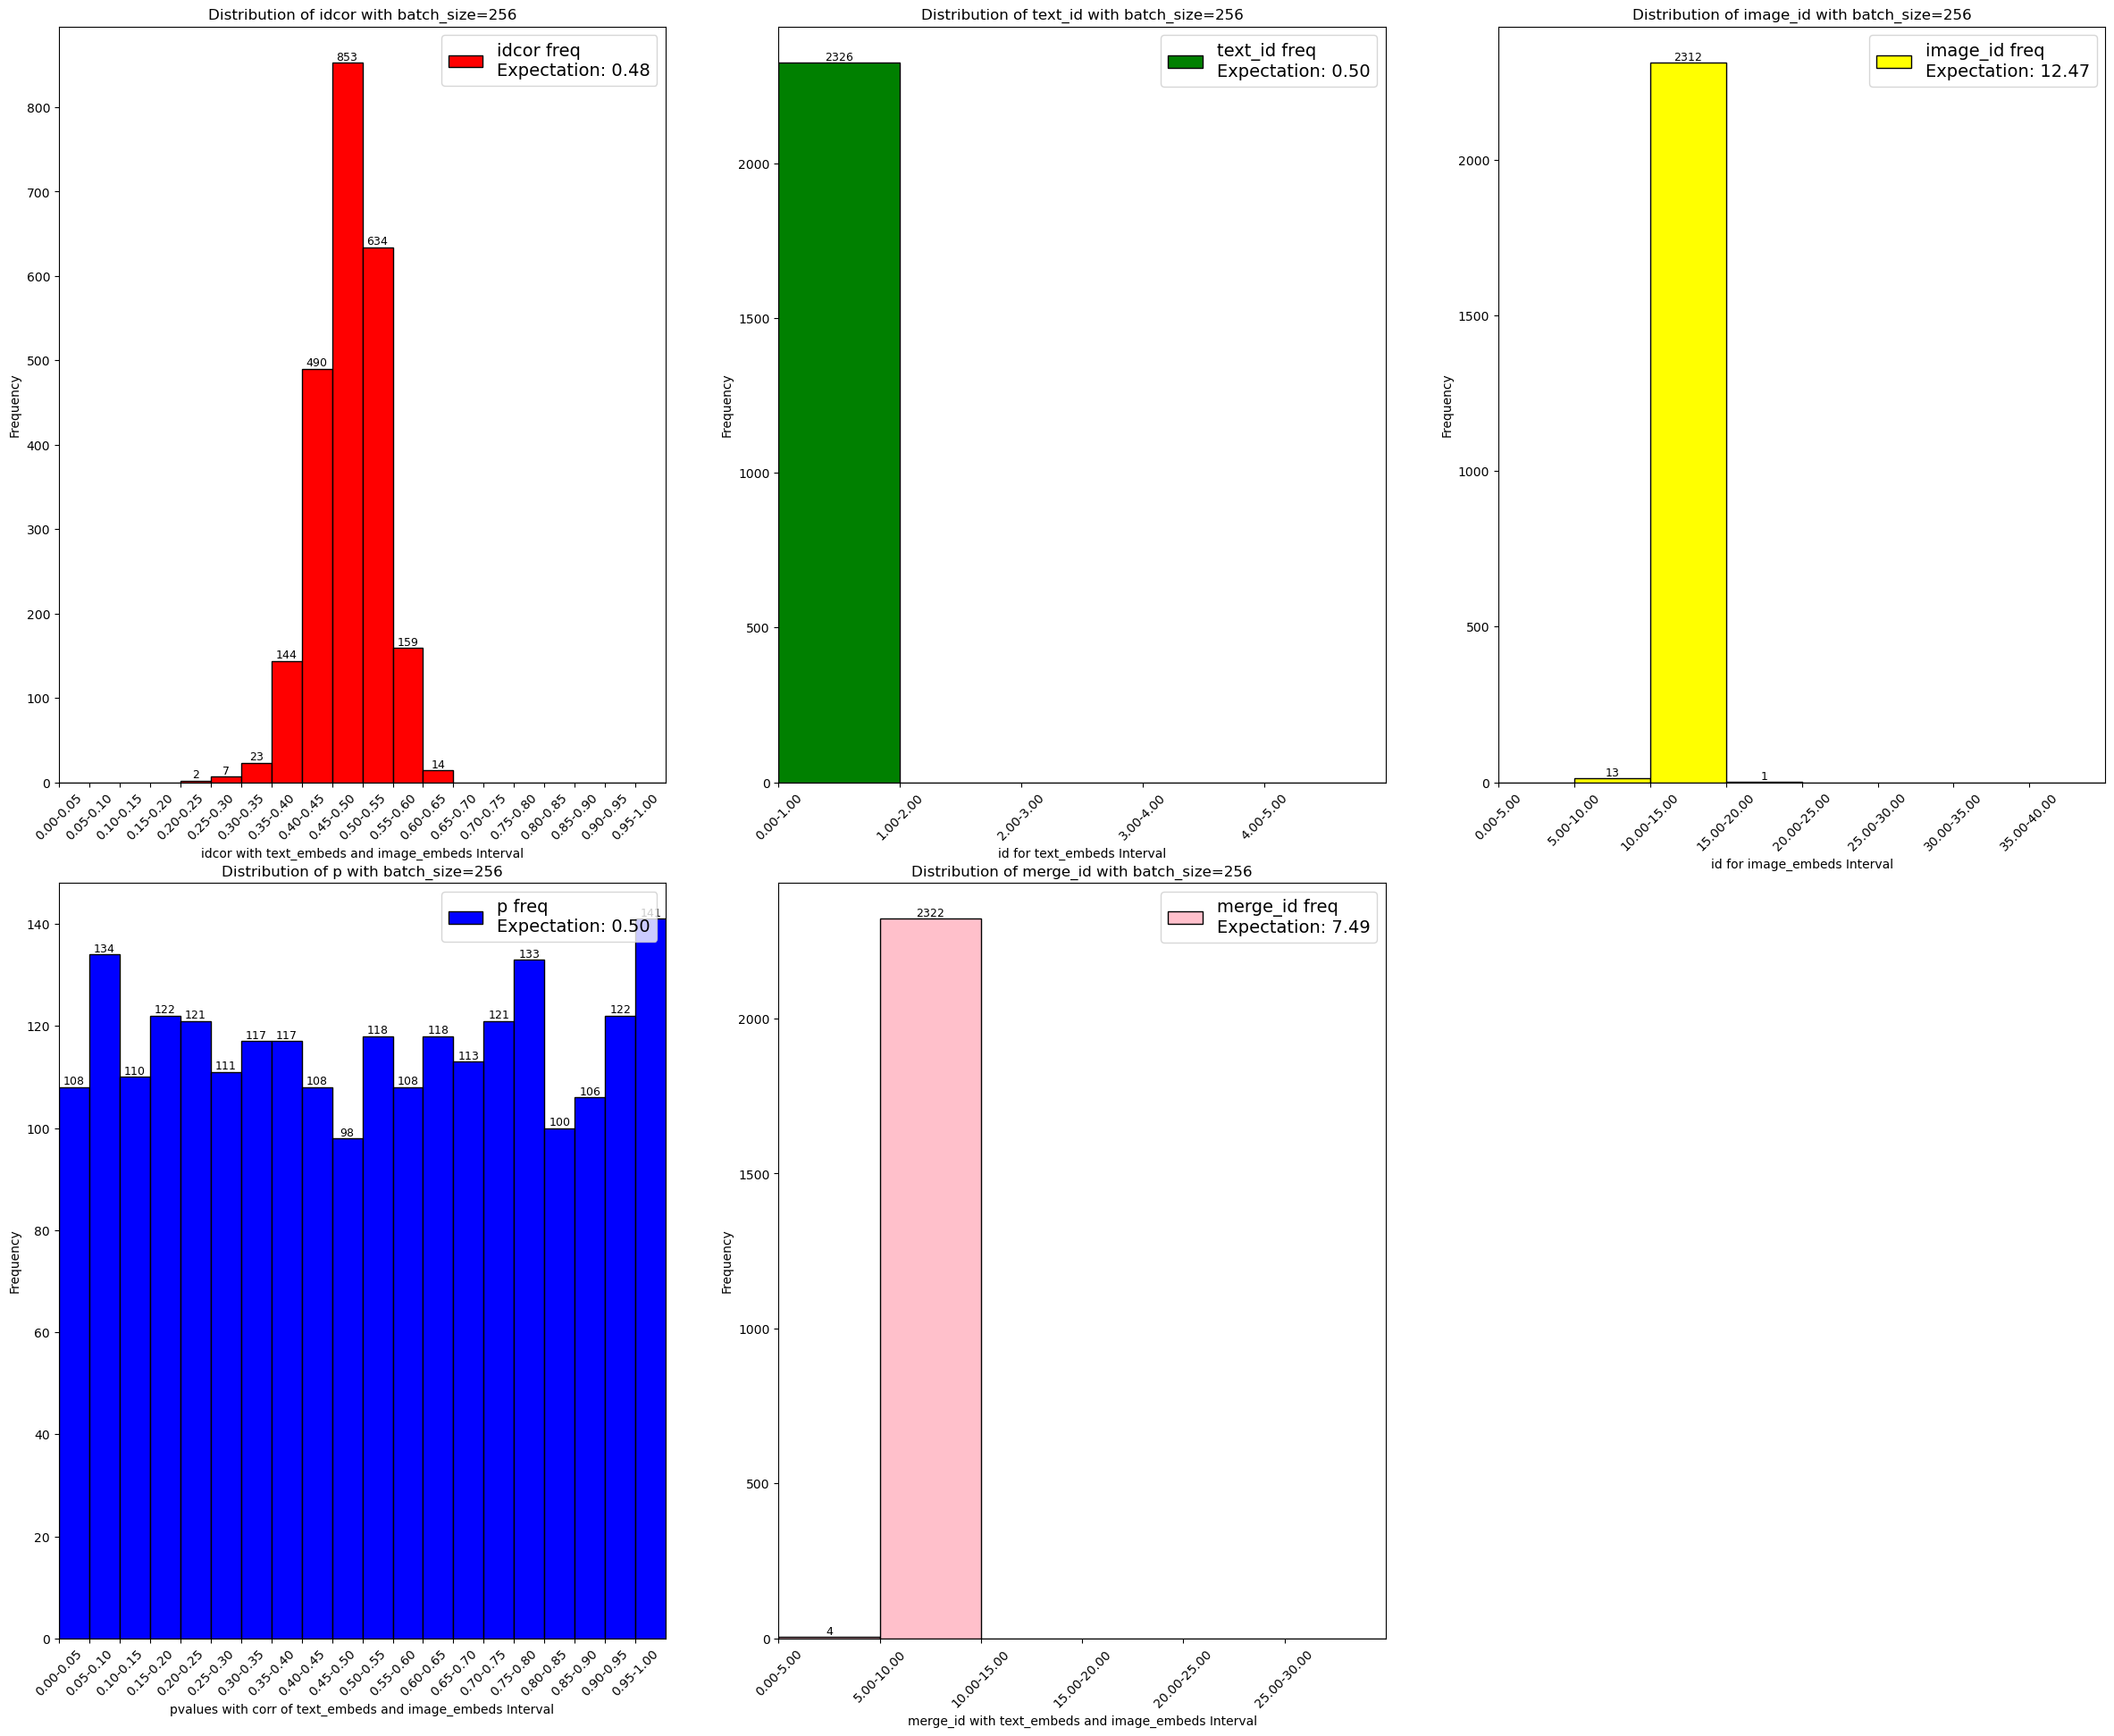

In [13]:
bin_start_list = [0.0, 0.0, 0.0, 0.0, 0.0]
bin_end_list = [1.0, 5.0, 40.0 ,1.0, 30.0]
bin_width_list = [0.05, 1.0, 5.0, 0.05, 5.0]
data_list = [idcor_list, text_id_list, image_id_list, p_list, merge_id_list]
name_list = ['idcor', 'text_id', 'image_id', 'p', 'merge_id']
color_list = ['red', 'green', 'yellow', 'blue', 'pink']
xlabel_list = [
    'idcor with text_embeds and image_embeds Interval',
    'id for text_embeds Interval',
    'id for image_embeds Interval',
    'pvalues with corr of text_embeds and image_embeds Interval',
    'merge_id with text_embeds and image_embeds Interval'
]

draw_corr_columnar_distribution(bin_start_list=bin_start_list, bin_end_list=bin_end_list, bin_width_list=bin_width_list, data_list=data_list, name_list=name_list, color_list=color_list, xlabel_list=xlabel_list, batch_size=batch_size)

In [5]:
textRepPath_1 = './representation/LLaVA-CC3M-Pretrain-595K/oldextra/stage1/trainjson_ck4000_qwen2.5_3B_Instruct_clipvL14_model_text_1.pt'
textRepPath_2 = './representation/LLaVA-CC3M-Pretrain-595K/oldextra/stage1/trainjson_ck4000_qwen2.5_3B_Instruct_clipvL14_model_text_2.pt'
imageRepPath_1 = './representation/LLaVA-CC3M-Pretrain-595K/oldextra/stage1/trainjson_ck4000_qwen2.5_3B_Instruct_clipvL14_model_image_1.pt'
imageRepPath_2 = './representation/LLaVA-CC3M-Pretrain-595K/oldextra/stage1/trainjson_ck4000_qwen2.5_3B_Instruct_clipvL14_model_image_2.pt'

text_reps_1 = torch.load(textRepPath_1)
text_reps_2 = torch.load(textRepPath_2)
image_reps_1 = torch.load(imageRepPath_1)
image_reps_2 = torch.load(imageRepPath_2)
text_reps = torch.cat((text_reps_1, text_reps_2), dim=0)
image_reps = torch.cat((image_reps_1, image_reps_2), dim=0)
text_reps.shape, image_reps.shape

(torch.Size([595375, 768]), torch.Size([595375, 2048]))

In [6]:
batch_size = 256
# 使用 torch.split 分割张量
text_reps_batches = torch.split(text_reps, batch_size)
image_reps_batches = torch.split(image_reps, batch_size)

In [7]:
text_id_list = []
image_id_list = []
idcor_list = []
p_list = []
merge_id_list = []

# 以batch_size为一批的大小，计算text_embeds与image_embeds之间的corr
for batch, (text_embeds, image_embeds) in tqdm(enumerate(zip(text_reps_batches, image_reps_batches))):
    corr = id_correlation(text_embeds.to(torch.float32), image_embeds.to(torch.float32), 100, id_alg)
    text_id_list.append(corr['id1'])
    image_id_list.append(corr['id2'])
    idcor_list.append(corr['corr'])
    p_list.append(corr['p'])
    merge_id_list.append(corr['id'])

2326it [05:36,  6.91it/s]


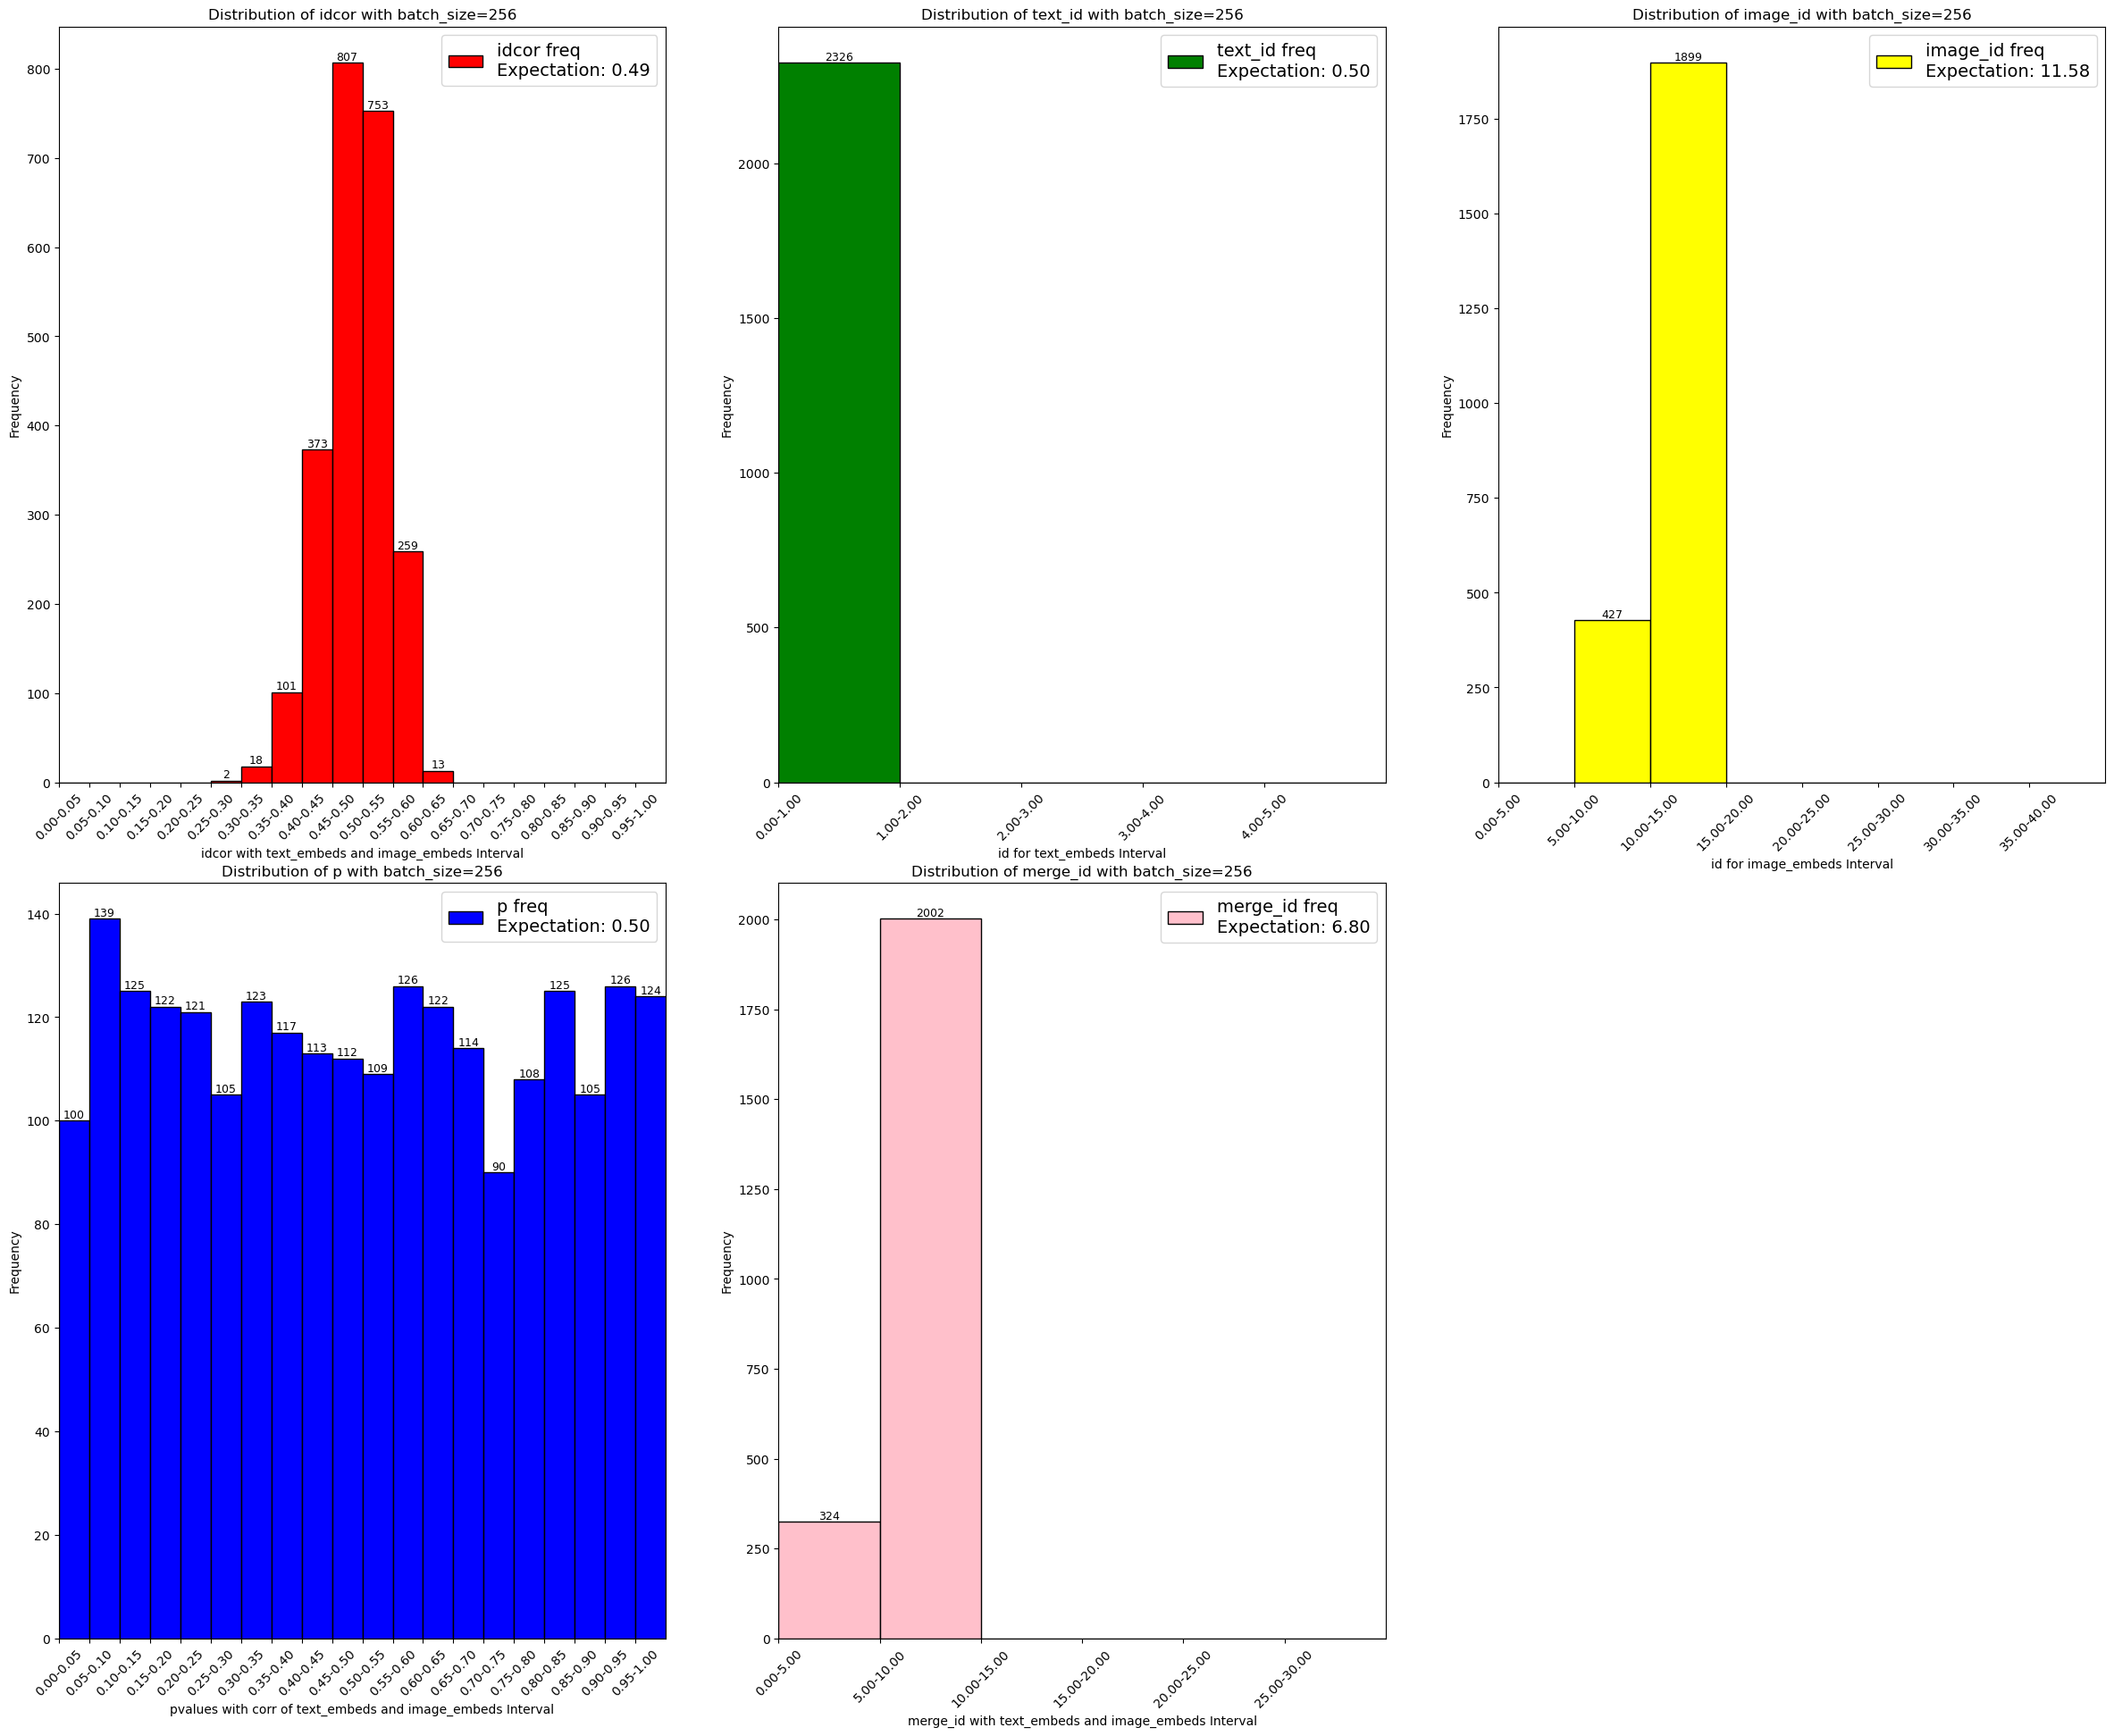

In [8]:
bin_start_list = [0.0, 0.0, 0.0, 0.0, 0.0]
bin_end_list = [1.0, 5.0, 40.0 ,1.0, 30.0]
bin_width_list = [0.05, 1.0, 5.0, 0.05, 5.0]
data_list = [idcor_list, text_id_list, image_id_list, p_list, merge_id_list]
name_list = ['idcor', 'text_id', 'image_id', 'p', 'merge_id']
color_list = ['red', 'green', 'yellow', 'blue', 'pink']
xlabel_list = [
    'idcor with text_embeds and image_embeds Interval',
    'id for text_embeds Interval',
    'id for image_embeds Interval',
    'pvalues with corr of text_embeds and image_embeds Interval',
    'merge_id with text_embeds and image_embeds Interval'
]

draw_corr_columnar_distribution(bin_start_list=bin_start_list, bin_end_list=bin_end_list, bin_width_list=bin_width_list, data_list=data_list, name_list=name_list, color_list=color_list, xlabel_list=xlabel_list, batch_size=batch_size)

In [4]:
textRepPath_1 = './representation/LLaVA-CC3M-Pretrain-595K/oldextra/stage1/trainjson_ck6000_qwen2.5_3B_Instruct_clipvL14_model_text_1.pt'
textRepPath_2 = './representation/LLaVA-CC3M-Pretrain-595K/oldextra/stage1/trainjson_ck6000_qwen2.5_3B_Instruct_clipvL14_model_text_2.pt'
imageRepPath_1 = './representation/LLaVA-CC3M-Pretrain-595K/oldextra/stage1/trainjson_ck6000_qwen2.5_3B_Instruct_clipvL14_model_image_1.pt'
imageRepPath_2 = './representation/LLaVA-CC3M-Pretrain-595K/oldextra/stage1/trainjson_ck6000_qwen2.5_3B_Instruct_clipvL14_model_image_2.pt'

text_reps_1 = torch.load(textRepPath_1)
text_reps_2 = torch.load(textRepPath_2)
image_reps_1 = torch.load(imageRepPath_1)
image_reps_2 = torch.load(imageRepPath_2)
text_reps = torch.cat((text_reps_1, text_reps_2), dim=0)
image_reps = torch.cat((image_reps_1, image_reps_2), dim=0)
text_reps.shape, image_reps.shape

(torch.Size([595375, 768]), torch.Size([595375, 2048]))

In [5]:
batch_size = 256
# 使用 torch.split 分割张量
text_reps_batches = torch.split(text_reps, batch_size)
image_reps_batches = torch.split(image_reps, batch_size)

In [6]:
text_id_list = []
image_id_list = []
idcor_list = []
p_list = []
merge_id_list = []

# 以batch_size为一批的大小，计算text_embeds与image_embeds之间的corr
for batch, (text_embeds, image_embeds) in tqdm(enumerate(zip(text_reps_batches, image_reps_batches))):
    corr = id_correlation(text_embeds.to(torch.float32), image_embeds.to(torch.float32), 100, id_alg)
    text_id_list.append(corr['id1'])
    image_id_list.append(corr['id2'])
    idcor_list.append(corr['corr'])
    p_list.append(corr['p'])
    merge_id_list.append(corr['id'])

2326it [05:40,  6.83it/s]


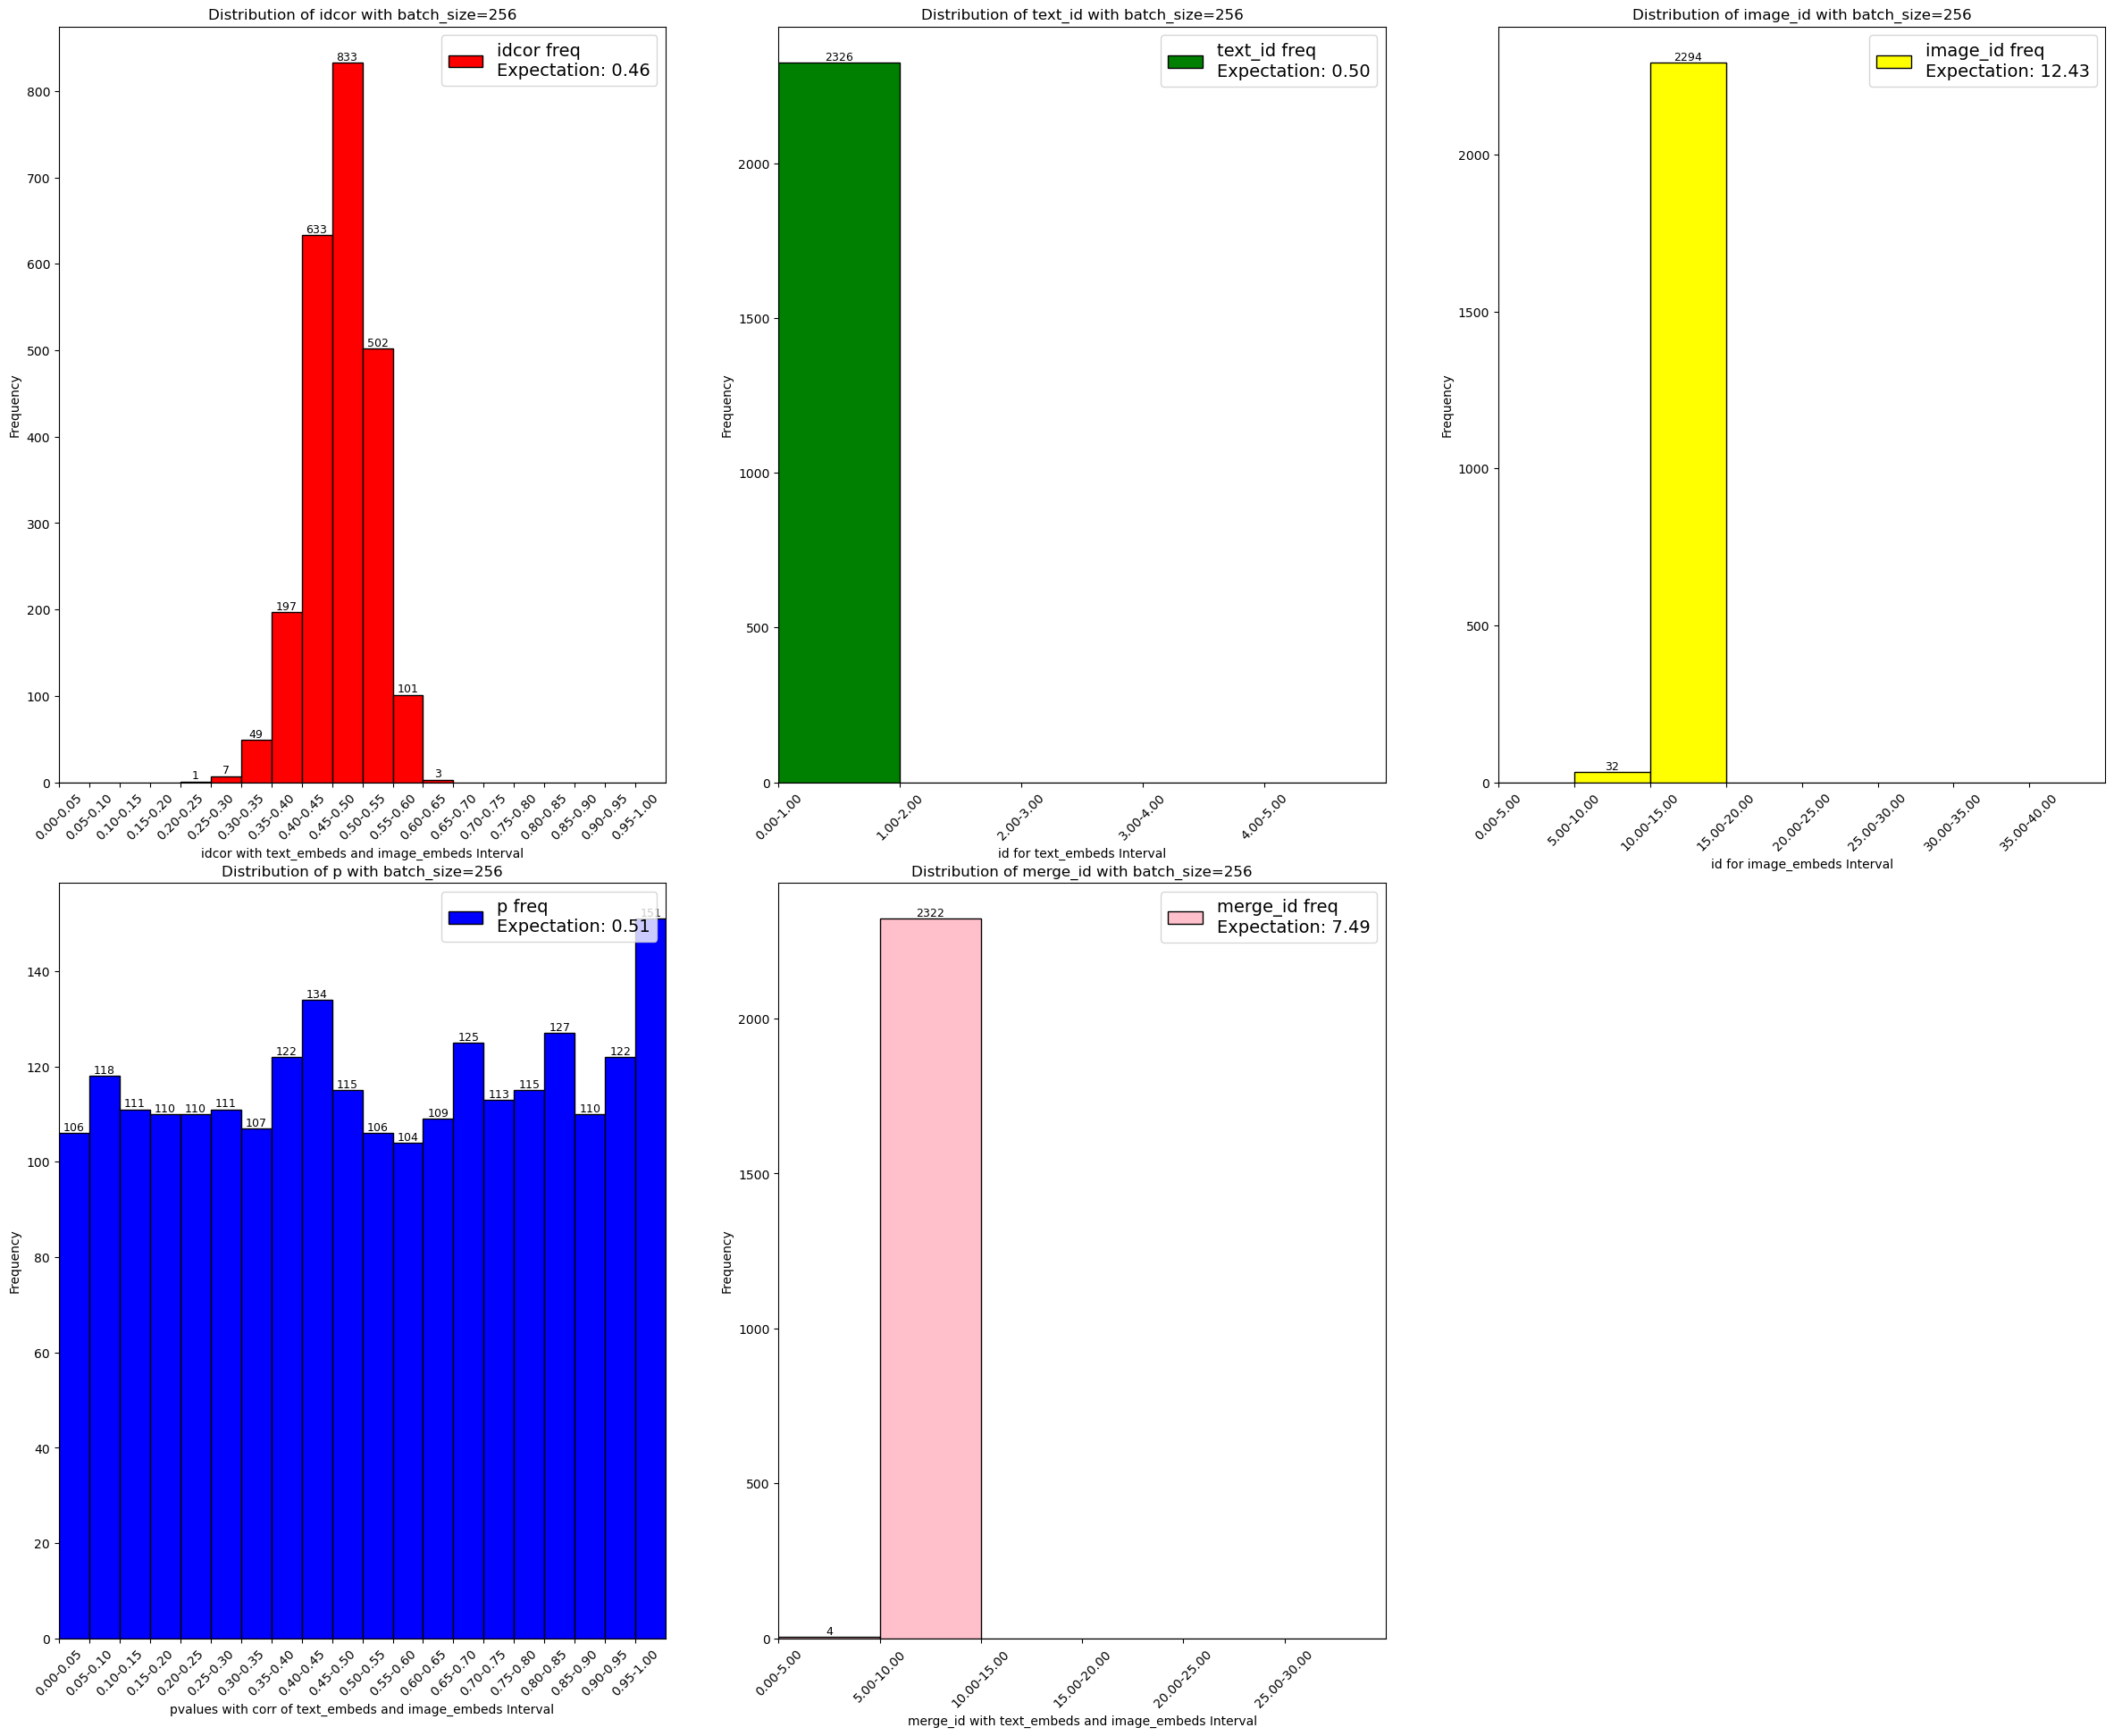

In [7]:
bin_start_list = [0.0, 0.0, 0.0, 0.0, 0.0]
bin_end_list = [1.0, 5.0, 40.0 ,1.0, 30.0]
bin_width_list = [0.05, 1.0, 5.0, 0.05, 5.0]
data_list = [idcor_list, text_id_list, image_id_list, p_list, merge_id_list]
name_list = ['idcor', 'text_id', 'image_id', 'p', 'merge_id']
color_list = ['red', 'green', 'yellow', 'blue', 'pink']
xlabel_list = [
    'idcor with text_embeds and image_embeds Interval',
    'id for text_embeds Interval',
    'id for image_embeds Interval',
    'pvalues with corr of text_embeds and image_embeds Interval',
    'merge_id with text_embeds and image_embeds Interval'
]

draw_corr_columnar_distribution(bin_start_list=bin_start_list, bin_end_list=bin_end_list, bin_width_list=bin_width_list, data_list=data_list, name_list=name_list, color_list=color_list, xlabel_list=xlabel_list, batch_size=batch_size)